<a href="https://colab.research.google.com/github/Jin-K-Yang/Clustering-by-Louvain-Algorithm/blob/main/louvain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from glob import glob

def louvain(filename):
  # load one excel file
  df = pd.read_excel(filename, usecols=['會員編號', '部門編號'], converters={'部門編號':str})
  df = df.dropna(how='any',axis=0) 

  # convert into two array which represent customer and product
  array = df.to_numpy()
  split_array = np.hsplit(array, 2)
  customer = split_array[0]
  product = split_array[1]

  # construct bipartite graph
  G = nx.Graph()
  for i in range(len(product)):
      # zero padding
      product[i][0] = product[i][0].zfill(5)

      # add nodes
      G.add_nodes_from(product[i], bipartite = 0)
      G.add_nodes_from(customer[i], bipartite = 1)
      
      # add edges
      if G.has_edge(product[i][0], customer[i][0]):
          G[product[i][0]][customer[i][0]]['weight'] += 1
      else:
          G.add_edge(product[i][0], customer[i][0], weight = 1)

  # show the total number of nodes and edges
  # print(G.number_of_nodes())
  # print(G.number_of_edges())

  # compute the best partition
  partition = community_louvain.best_partition(G)
  # print(partition)

  # classify the result
  community = {}
  for key, value in set(partition.items()):
      if key[0].isalpha():
          community.setdefault(value, {}).setdefault('customer', []).append(key)
      else:
          community.setdefault(value, {}).setdefault('product', []).append(key)

  # calculate the sum of edges of clusters
  for i in range(len(community)):
    SG = G.subgraph(community[i]['product'] + community[i]['customer'])
    community[i]['edges_sum'] = SG.number_of_edges()
  return community
  """
  total_name=''
  for i in range(len(community)):
    print(i)
    for j in community[i]['product']:
      total_name += num_to_product(j)
      total_name += ' , '
    print(total_name)
    total_name=''
  """

# folder version
def louvain_folder(filename):
  # load multiple excel file
  files = glob(filename)
  df = pd.concat([pd.read_excel(f, usecols=['會員編號', '部門編號'], converters={'部門編號':str}) for f in files])
  df.dropna(how='any',axis=0)
  df.reset_index(drop=True)

  # convert into two array which represent customer and product
  array = df.to_numpy()
  split_array = np.hsplit(array, 2)
  customer = split_array[0]
  product = split_array[1]

  # construct bipartite graph
  G = nx.Graph()
  for i in range(len(product)):
      # zero padding
      product[i][0] = product[i][0].zfill(5)

      # add nodes
      G.add_nodes_from(product[i], bipartite = 0)
      G.add_nodes_from(customer[i], bipartite = 1)
      
      # add edges
      if G.has_edge(product[i][0], customer[i][0]):
          G[product[i][0]][customer[i][0]]['weight'] += 1
      else:
          G.add_edge(product[i][0], customer[i][0], weight = 1)

  # show the total number of nodes and edges
  # print(G.number_of_nodes())
  # print(G.number_of_edges())

  # compute the best partition
  partition = community_louvain.best_partition(G)

  # classify the result
  community = {}
  for key, value in set(partition.items()):
      if key[0].isalpha():
          community.setdefault(value, {}).setdefault('customer', []).append(key)
      else:
          community.setdefault(value, {}).setdefault('product', []).append(key)

  # calculate the sum of edges of clusters
  for i in range(len(community)):
    SG = G.subgraph(community[i]['product'] + community[i]['customer'])
    community[i]['edges_sum'] = SG.number_of_edges()
  return community

# benefit-cost analysis
def benefit_cost(community):
  benefit = {
      'Customer_Count':[],
      'Product_Count':[],
      'Cost':[],
      'Benefit':[],
      'Ratio':[]
  }

  total = {
      'Customer_Count':0,
      'Product_Count':0,
      'Cost':0,
      'Benefit':0,
      'Ratio':0
  }

  for i in range(len(community)):
      benefit['Customer_Count'].append(len(community[i]['customer']))
      benefit['Product_Count'].append(len(community[i]['product']))
      benefit['Cost'].append(len(community[i]['customer']) * len(community[i]['product']))
      benefit['Benefit'].append(community[i]['edges_sum'])
      benefit['Ratio'].append(community[i]['edges_sum'] / (len(community[i]['customer']) * len(community[i]['product'])))

      total['Customer_Count'] += len(community[i]['customer'])
      total['Product_Count'] += len(community[i]['product'])
      total['Cost'] += len(community[i]['customer']) * len(community[i]['product'])
      total['Benefit'] += community[i]['edges_sum']

  total['Ratio'] = total['Benefit'] / total['Cost']

  df_total = pd.DataFrame(total, index=['total'])
  df_benefit = pd.DataFrame(benefit)

  result = pd.concat([df_benefit, df_total])
  return result

# map the department number and deparment name from excel file
def map_department(file):
  map_df = pd.read_excel(file, usecols=['部門名稱', '部門編號'], converters={'部門編號':str})
  map_array = np.hsplit(map_df.to_numpy(), 2)
  map = {}

  for i in range(len(map_array[0])):
    map[map_array[0][i][0].zfill(5)] = map_array[1][i][0]
  return map

# show the product name in each clusters
def show_product(map, community):
  for i in range(len(community)):
    for j in range(len(community[i]['product'])):
      community[i]['product'][j] = map[community[i]['product'][j]]
    print(community[i]['product'])

In [ ]:
result_2018 = louvain('/content/drive/Shareddrives//louvain/year/2018.xlsx')
benefit_cost_2018 = benefit_cost(result_2018)
benefit_cost_2018

In [ ]:
result_2019 = louvain('/content/drive/Shareddrives//louvain/year/2019.xlsx')
benefit_cost_2019 = benefit_cost(result_2019)
benefit_cost_2019

In [ ]:
result_2020 = louvain('/content/drive/Shareddrives//louvain/year/2020.xlsx')
benefit_cost_2020 = benefit_cost(result_2020)
benefit_cost_2020

In [ ]:
map = map_department('/content/drive/Shareddrives//louvain/department_list.xlsx')
show_product(map, result_2018)

In [ ]:
map = map_department('/content/drive/Shareddrives//louvain/department_list.xlsx')
show_product(map, result_2019)

In [ ]:
map = map_department('/content/drive/Shareddrives//louvain/department_list.xlsx')
show_product(map, result_2020)

In [54]:
# write result to the excel file
from openpyxl import load_workbook

def write_clusters(file_name, sheetname, result):
  wb = load_workbook(filename = file_name)
  sheet = wb[sheetname]
  for i in range(len(result)):
    for j in range(len(result[i]['product'])):
      sheet.cell(row=i+2, column=7+j).value = result[i]['product'][j]
  wb.save(file_name)

with pd.ExcelWriter('/content/drive/Shareddrives//louvain/total_result.xlsx') as writer:  
  benefit_cost_2018.to_excel(writer, sheet_name='2018')
  benefit_cost_2019.to_excel(writer, sheet_name='2019')
  benefit_cost_2020.to_excel(writer, sheet_name='2020')

write_clusters('/content/drive/Shareddrives//louvain/total_result.xlsx', '2018', result_2018)
write_clusters('/content/drive/Shareddrives//louvain/total_result.xlsx', '2019', result_2019)
write_clusters('/content/drive/Shareddrives//louvain/total_result.xlsx', '2020', result_2020)

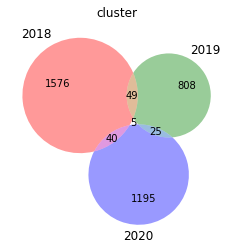

In [70]:
#compare each clusters' people if they are same and draw the Venn diagram
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt

def compare_two_years(cluster_1, cluster_2):
  count = 0
  for i in range(len((cluster_1['customer']))):
    for j in range(len(cluster_2['customer'])):
      if cluster_1['customer'][i] == cluster_2['customer'][j]:
        count += 1
  return count

def compare_three_years(cluster_1, cluster_2, cluster_3):
  count = 0
  for i in range(len((cluster_1['customer']))):
    for j in range(len(cluster_2['customer'])):
      if cluster_1['customer'][i] == cluster_2['customer'][j]:
        for k in range(len(cluster_3['customer'])):
          if cluster_1['customer'][i] == cluster_3['customer'][k]:
            count += 1
  return count

def draw_Venn_diagram(cluster_1, cluster_2, cluster_3):
  venn3(subsets = (len(cluster_1['customer']), len(cluster_2['customer']), compare_two_years(cluster_1, cluster_2), len(cluster_3['customer']), compare_two_years(cluster_1, cluster_3), compare_two_years(cluster_2, cluster_3), compare_three_years(cluster_1, cluster_2, cluster_3)), set_labels = ('2018', '2019', '2020'))

draw_Venn_diagram(result_2018[10], result_2019[17], result_2020[19])
plt.title('cluster');

In [ ]:
# draw the graph
pos = nx.spring_layout(G)

# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=1, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta
from matplotlib_venn import venn2
from matplotlib_venn import venn2_circles
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
import time


class RFM:
    def __init__(self, i_file, p_e_date, 
                 p_s_date='default', t_s_date='default', bucket_num=100, recency_ascending=True):
        self.i_file = i_file
        self.date_format = '%Y%m%d'
        self.bucket_num = bucket_num
        self.recency_ascending = recency_ascending
        # 讀取檔案
        self.df = pd.read_csv(self.i_file, usecols=['會員編號', '交易日期', '交易金額'])
        # 從原始欄位中篩選所要的欄位，並重新命名成英文欄位名稱
        self.df = self.df.loc[:, ['會員編號', '交易日期', '交易金額']]
        self.df.columns = ['ID', 'T_DATE', 'AMOUNT']
        # 將日期改成日期格式
        self.df['T_DATE'] = pd.to_datetime(self.df['T_DATE'], format=self.date_format)
        # 先排序交易日期，後排序會員編號
        self.df.sort_values(by=['ID', 'T_DATE'])
        # 2. 切割訓練資料、回購標記與驗證資料
        # #### 資料期間 ######
        self.data_start_date = self.df['T_DATE'].sort_values().iloc[1]  
        self.data_end_date = self.df['T_DATE'].sort_values().iloc[-1]  # 擁有資料中的最後日期
        self.data_duration = self.data_end_date - self.data_start_date + timedelta(days=1)
        # #### 預測期間 ######
        if p_s_date == 'default':
            self.predict_start_date = self.data_end_date + timedelta(days=1)
        else:
            self.predict_start_date = pd.Timestamp(p_s_date)
        self.predict_end_date = pd.Timestamp(p_e_date)
        self.predict_duration = self.predict_end_date - self.predict_start_date + timedelta(days=1)
        # #### 訓練期間 ######
        if t_s_date == 'default':
            self.train_start_date = self.data_start_date
        else:
            self.train_start_date = pd.Timestamp(t_s_date)
        self.train_end_date = self.predict_start_date - self.predict_duration - timedelta(days=1)
        self.train_duration = self.train_end_date - self.train_start_date + timedelta(days=1)
        # #### 回購標記 ######
        self.repurchase_start_date = self.train_end_date + timedelta(days=1)
        self.repurchase_end_date = self.train_end_date + self.predict_duration
        # #### 驗證期間 ######
        self.test_start_date = self.train_start_date + self.predict_duration
        self.test_end_date = self.test_start_date + self.train_duration - timedelta(days=1)
        
    @staticmethod
    def regen_rfm(df1, df2, bucket_num = 100):
        df2.R = df1.R.max() + df2.R
        basis_data = pd.concat([df1, df2], ignore_index=True)
        # 計算RFM值
        Pred = pd.DataFrame()
        Pred['R'] = basis_data.groupby('ID')['R'].max()
        Pred['F'] = basis_data.groupby('ID')['F'].sum()
        Pred['M'] = basis_data.groupby('ID')['M'].sum()
        Pred['ID'] = Pred.index
        Pred = Pred[['ID', 'R', 'F', 'M']]
        # 產生BUCKET值
        rows = len(Pred.index)
        data = np.ones(rows, dtype=np.int)
        s = pd.Series(data)
        bucket_size = int(rows/bucket_num)+1
        for i in range(bucket_num-1):
            s.iloc[bucket_size*i:bucket_size*(i+1)] = bucket_num-i
        Pred = Pred.sort_values(by=['R', 'ID'], ascending=[False, True])
        Pred['RB'] = s.values
        Pred = Pred.sort_values(by=['F', 'R', 'ID'], ascending=[False, False, True])
        Pred['FB'] = s.values
        Pred = Pred.sort_values(by=['M', 'F', 'R', 'ID'],
                                    ascending=[False, False, False, True])
        Pred['MB'] = s.values
        Pred = Pred.sort_values(by='ID')
        return Pred
    
    def get_info(self, o_file='default'):
        sort = 'desc'
        if self.recency_ascending:
            sort = 'asc'
        if o_file == 'default':
            o_file = '{:0>4d}{:0>2d}{:0>2d}_{:0>4d}{:0>2d}{:0>2d}-{:0>2d}{:0>2d}_{}_info.csv'.format(
                        self.train_start_date.year, self.train_start_date.month, self.train_start_date.day,
                        self.predict_start_date.year, self.predict_start_date.month, self.predict_start_date.day,
                        self.predict_end_date.month, self.predict_end_date.day, sort)
        info = pd.DataFrame()
        info['開始日期'] = [self.data_start_date, self.train_start_date, self.repurchase_start_date,
                        self.test_start_date, self.predict_start_date]
        info['結束日期'] = [self.data_end_date, self.train_end_date, self.repurchase_end_date,
                        self.test_end_date, self.predict_end_date]
        info['計算天數'] = (info['結束日期'] - info['開始日期'] + timedelta(days=1)).apply(lambda x: x.days)

        def count_member(d1, d2):
            mask1 = self.df['T_DATE'] >= d1
            mask2 = self.df['T_DATE'] <= d2
            return self.df[mask1 & mask2].ID.nunique()
        info['交易人數'] = info.apply(lambda x: count_member(x['開始日期'], x['結束日期']), axis=1)
        info.index = ['資料期間', '訓練期間', '回購標記', '驗證期間', '預測期間']
        # 輸出檔案
        info.to_csv(o_file)
        return o_file
    # 處理訓練資料
        
    def gen_train(self, o_file='default', oversampling=4, features=['R', 'F', 'M']):
        sort = 'desc'
        if self.recency_ascending:
            sort = 'asc'
        if o_file == 'default':
            o_file = '{:0>4d}{:0>2d}{:0>2d}_{:0>4d}{:0>2d}{:0>2d}-{:0>2d}{:0>2d}_{}_train_o{}.csv'.format(
                        self.train_start_date.year, self.train_start_date.month, self.train_start_date.day,
                        self.predict_start_date.year, self.predict_start_date.month, self.predict_start_date.day,
                        self.predict_end_date.month, self.predict_end_date.day, sort, oversampling)
        mask1 = self.df['T_DATE'] >= self.train_start_date
        mask2 = self.df['T_DATE'] <= self.train_end_date
        data = self.df[mask1 & mask2]
        result = self.gen_rfm(data, 'train', features)
        # 計算REPURCHASE值
        # 找出回購標記範圍
        mask1 = self.df['T_DATE'] >= self.repurchase_start_date
        mask2 = self.df['T_DATE'] <= self.repurchase_end_date
        repurchase = self.df[mask1 & mask2]
        result['REPURCHASE'] = pd.Series(result.index.isin(repurchase['ID'])).astype('int').values
        repurchase_success = result[result.REPURCHASE == 1]
        # Oversampling
        if oversampling > 0:
            for _ in range(oversampling-1):
                result = result.append(repurchase_success, ignore_index=True)
        # 按照ID作排序
        result = result.sort_values(by=['ID'], ascending=[True])
        # 輸出檔案
        result.to_csv(o_file, index=False)
        return o_file
    
    # 處理驗證資料
    def gen_val(self, o_file='default', features=['R', 'F', 'M']):
        sort = 'desc'
        if self.recency_ascending:
            sort = 'asc'
        if o_file == 'default':
            o_file = '{:0>4d}{:0>2d}{:0>2d}_{:0>4d}{:0>2d}{:0>2d}-{:0>2d}{:0>2d}_{}_val.csv'.format( 
                        self.train_start_date.year, self.train_start_date.month, self.train_start_date.day,
                        self.predict_start_date.year, self.predict_start_date.month, self.predict_start_date.day,
                        self.predict_end_date.month, self.predict_end_date.day, sort)
        mask1 = self.df['T_DATE'] >= self.test_start_date
        mask2 = self.df['T_DATE'] <= self.test_end_date
        data = self.df[mask1 & mask2]
        result = self.gen_rfm(data, 'val', features)
        # 計算REPURCHASE值
        # 找出回購標記範圍
        mask1 = self.df['T_DATE'] >= self.predict_start_date
        mask2 = self.df['T_DATE'] <= self.predict_end_date
        repurchase = self.df[mask1 & mask2]
        result['REPURCHASE'] = pd.Series(result.index.isin(repurchase['ID'])).astype('int').values
        repurchase_amt = repurchase.groupby('ID')['AMOUNT'].sum()
        result = result.merge(repurchase_amt.to_frame(), on='ID', how='left')
        # 按照ID作排序
        result = result.sort_values(by=['ID'], ascending=[True])
        # 輸出檔案
        result.to_csv(o_file, index=False)
        return o_file
        # 處理測試資料

    def gen_test(self, o_file='default', features=['R', 'F', 'M']):
        sort = 'desc'
        if self.recency_ascending:
            sort = 'asc'
        if o_file == 'default':
            o_file = '{:0>4d}{:0>2d}{:0>2d}_{:0>4d}{:0>2d}{:0>2d}-{:0>2d}{:0>2d}_{}_test.csv'.format( 
                        self.train_start_date.year, self.train_start_date.month, self.train_start_date.day,
                        self.predict_start_date.year, self.predict_start_date.month, self.predict_start_date.day,
                        self.predict_end_date.month, self.predict_end_date.day, sort)
        mask1 = self.df['T_DATE'] >= self.test_start_date
        mask2 = self.df['T_DATE'] <= self.test_end_date
        data = self.df[mask1 & mask2]
        result = self.gen_rfm(data, 'test', features)
        # 按照ID作排序
        result = result.sort_values(by=['ID'], ascending=[True])
        # 輸出檔案
        result.to_csv(o_file, index=False)
        return o_file

    def gen_rfm(self, data, date_for='train', features=['R', 'F', 'M']):
        time_stamp = time.time()
        # 將時間更改成相同基底
        def change_r_basis(x):
            if date_for == 'train':
                if self.recency_ascending:  # 奇廷日期基數校正
                    return (x - self.train_start_date + timedelta(days=1)).days
                else:                       # 製圖用倒推日期基數
                    return (self.train_end_date - x + timedelta(days=1)).days
            else:  # date_for='val', date_for='test'
                if self.recency_ascending:  # 奇廷日期基數校正
                    return (x - self.test_start_date + timedelta(days=1)).days
                else:                       # 製圖用倒推日期基數
                    return (self.test_end_date - x + timedelta(days=1)).days

        def id_trans(id_str):  # 取代全型字體為半型
            return id_str.translate(str.maketrans('０１２３４５６７８９', '0123456789'))
        
        basis_data = data.copy()
        basis_data['T_DATE'] = data['T_DATE'].apply(change_r_basis).copy()
        basis_data['ID'] = data['ID'].apply(id_trans).copy()
        # 計算RFM值
        result = pd.DataFrame()
        
        if self.recency_ascending:  # 奇廷日期基數校正
            result['R'] = basis_data.groupby('ID')['T_DATE'].max()
        else:
            result['R'] = basis_data.groupby('ID')['T_DATE'].min()
        if features.count('L') > 0: 
            result['FR'] = basis_data.groupby('ID')['T_DATE'].min()
            result['L'] = result['R'] - result['FR']
        result['F'] = basis_data.groupby('ID')['T_DATE'].nunique()  # 取代原本奇廷day merge的作法
        result['M'] = basis_data.groupby('ID')['AMOUNT'].sum()

        # 新增CAI算法     
        def get_avg_p(series):
            df = pd.Series(series.unique())
            if len(df)==1:
                return 0
            df = df.sort_values()
            df = df.diff().dropna()
            return df.mean()
        def get_wei_p(series):
            df = pd.Series(series.unique())
            if len(df)==1:
                return 0
            df = df.sort_values()
            df = df.diff().dropna()
            df_rows = len(df)
            df.index = np.arange(1, df_rows + 1)
            return (df.index*df).sum()/((df_rows+df_rows*df_rows)/2)
        if features.count('CAI') > 0 or features.count('NPT') > 0:
            result['AVG_P'] = basis_data.groupby('ID')['T_DATE'].apply(get_avg_p)
        if features.count('CAI') > 0 or features.count('WNPT') > 0:
            result['WEI_P'] = basis_data.groupby('ID')['T_DATE'].apply(get_wei_p)
        if features.count('CAI') > 0:
            result['CAI'] = 1 - result['WEI_P']/result['AVG_P']
            result['CAI'] = result['CAI'].fillna(0)
        if features.count('NPT') > 0:    
            result['NPT'] = result['R'] + result['AVG_P']
        if features.count('WNPT') > 0: 
            result['WNPT']  = result['R'] + result['WEI_P']

        # 新增CCC算法
        def get_ccc(g):
            r = g.T_DATE.max()
            m1 = g[g.T_DATE > r-30].AMOUNT.sum()
            m6 = g[g.T_DATE > r-180].AMOUNT.sum()/6
            return m1/m6
        if features.count('CCC') > 0:
            result['CCC'] = basis_data.groupby('ID').apply(get_ccc)
        
        result['ID'] = result.index
        result.index.name = 'Index'
        result = result[['ID']+features]
        # 產生BUCKET值
        rows = len(result.index)
        data = np.ones(rows, dtype=np.int)
        s = pd.Series(data)
        bucket_size = int(rows/self.bucket_num)+1
        for i in range(self.bucket_num-1):
            s.iloc[bucket_size*i:bucket_size*(i+1)] = self.bucket_num-i
        result = result.sort_values(by=['R', 'ID'], ascending=[not self.recency_ascending, True])
        result['RB'] = s.values
        result = result.sort_values(by=['F', 'R', 'ID'], ascending=[False, not self.recency_ascending, True])
        result['FB'] = s.values
        result = result.sort_values(by=['M', 'F', 'R', 'ID'],
                                    ascending=[False, False, not self.recency_ascending, True])
        result['MB'] = s.values
        result = result.sort_values(by='ID')
        return result
    
class Forest:  
    @staticmethod
    def gen_result(train_file, test_file, o_file='default', seed=0, features=['R', 'F', 'M', 'RB', 'FB', 'MB']):
        if o_file == 'default':
            o_file = train_file.replace('train', 'result')
        result = Forest.get_result(train_file, test_file, seed, features)
        result.to_csv(o_file, index=False)
        return o_file
    @staticmethod
    def get_result(train_file, test_file, seed=0, features=['R', 'F', 'M', 'RB', 'FB', 'MB']):
        train = pd.read_csv(train_file)
        test = pd.read_csv(test_file)

        Train = train.loc[:, features]
        label = train.loc[:, ['REPURCHASE']]
        Test = test.loc[:,  features]
        Result = test.loc[:,  ['ID']+features]
        d = len(features) #特徵值數量==樹深度
        
        clf = RandomForestClassifier(n_estimators=30, max_depth=d, min_samples_leaf=2, random_state=seed,
                                     criterion='entropy')
        clf.fit(Train, label.values.ravel())
        p = pd.DataFrame(clf.predict_proba(Test))
        pred = p.iloc[:, 1]
        Result['Pred'] = pred
        return Result    
    
class Naive:
    @staticmethod
    def get_result(train_file, test_file, features=['R', 'F', 'M', 'RB', 'FB', 'MB']):
        train = pd.read_csv(train_file)
        test = pd.read_csv(test_file)

        Train = train.loc[:, features]
        label = train.loc[:, ['REPURCHASE']]
        Test = test.loc[:,  features]
        Result = test.loc[:,  ['ID']+features]

        clf = GaussianNB()
        clf.fit(Train, label.values.ravel())
        p = pd.DataFrame(clf.predict_proba(Test))
        pred = p.iloc[:, 1]
        Result['Pred'] = pred
        return Result
    
class SVM:
    @staticmethod
    def get_result(train_file, test_file, features=['R', 'F', 'M', 'RB', 'FB', 'MB']):
        train = pd.read_csv(train_file)
        test = pd.read_csv(test_file)

        Train = train.loc[:, features]
        label = train.loc[:, ['REPURCHASE']]
        Test = test.loc[:,  features]
        Result = test.loc[:,  ['ID']+features]

        clf = LinearSVC(random_state=1, tol=1e-5)
        clf.fit(Train, label.values.ravel())
        Result['Pred'] = clf.predict(Test)
        return Result    
    
class Diagram:
    
    @staticmethod
    def draw_r_diagram(val_file, axes, title, y_max='default'):
        df = pd.read_csv(val_file)
        r_max = np.max(df.R)
        df.R = r_max - df.R + 1  # 轉成desc
        r_max = 36*30  # 觀察三年
        b = np.arange(1, r_max+30, 30)   
        hist = df[df.REPURCHASE == 1].R.hist(bins=b, label='Repurchase Customer', ax=axes, color='darkorange')
        fd = {'fontsize': 18}
        hist.set_title(title, fontdict=fd)
        fd = {'fontsize': 16}
        hist.set_xlabel('Recency (last month)', fontdict=fd)
        hist.set_ylabel('Customers', fontdict=fd)
        hist.legend()
        hist.set_xticks(np.arange(1, r_max+60, 60))  # 以兩個月為單位
        hist.set_xticklabels(np.arange(0, int((r_max+60)/30), 2))
        hist.set_xlim(0, r_max)
        if not y_max == 'default':
            hist.set_ylim(0, y_max)
        count1, division1 = np.histogram(df[df.REPURCHASE == 1].R, bins=b)
        df_d = pd.DataFrame({'Repurchase Customer': count1})
        df_transpose = df_d.T
        return df_transpose

    @staticmethod
    def draw_p_r_diagram(result_file, th, axes, title, y_max='default'):
        df = pd.read_csv(result_file)
        r_max = np.max(df.R)
        df.R = r_max - df.R + 1  # 轉成desc
        r_max = 36*30  # 觀察三年
        b = np.arange(1, r_max+30, 30)   
        hist = df[df['Pred'] >= th].R.hist(bins=b, 
                                           label='Repurchase Customer(Threshold=={})'.format(th),
                                           ax=axes, color='magenta')
        fd = {'fontsize': 18}
        hist.set_title(title, fontdict=fd)
        fd = {'fontsize': 16}
        hist.set_xlabel('Recency (last month)', fontdict=fd)
        hist.set_ylabel('Customers', fontdict=fd)
        hist.legend()
        hist.set_xticks(np.arange(1, r_max+60, 60))  # 以兩個月為單位
        hist.set_xticklabels(np.arange(0, int((r_max+60)/30), 2))
        hist.set_xlim(0, r_max)
        if not y_max == 'default':
            hist.set_ylim(0, y_max)
        count1, division1 = np.histogram(df[df['Pred'] >= th].R, bins=b)
        df_d = pd.DataFrame({'Repurchase Customer': count1})
        df_transpose = df_d.T
        return df_transpose

    @staticmethod
    def draw_f_diagram(val_file, axes, title):
        df = pd.read_csv(val_file)
        b = np.arange(1, 31, 1)    
        hist = df[(df.REPURCHASE == 0) & (df.F <= 30)].F.hist(bins=b, label='Non-Repurchase Customer',
                                                              ax=axes, color='blue')
        df[(df.REPURCHASE == 1) & (df.F <= 30)].F.hist(bins=b, label='Repurchase Customer',
                                                       ax=axes, color='darkorange')
        fd = {'fontsize': 18}
        hist.set_title(title, fontdict=fd)
        fd = {'fontsize': 16}
        hist.set_xlabel('Frequecy', fontdict=fd)
        hist.set_ylabel('Customers', fontdict=fd)
        hist.legend()
        hist.set_xlim(1, 31)
        hist.set_xticks(np.arange(1, 32, 5))
        hist.set_xticklabels(np.arange(0, 31, 5))
        count1, division1 = np.histogram(df[(df.REPURCHASE == 0) & (df.F <= 30)].F, bins=b)
        count2, division2 = np.histogram(df[(df.REPURCHASE == 1) & (df.F <= 30)].F, bins=b)
        df_d = pd.DataFrame({'Non-Repurchase Customer': count1, 'Repurchase Customer': count2})
        df_transpose = df_d.T
        return df_transpose

    @staticmethod
    def draw_m_diagram(val_file, axes, title):
        df = pd.read_csv(val_file)
        b = 50  
        hist = df[(df.REPURCHASE == 0) & (df.M <= 50000)].M.hist(bins=b, label='Non-Repurchase Customer',
                                                                 ax=axes, color='blue', xrot=90)
        df[(df.REPURCHASE == 1) & (df.M <= 50000)].M.hist(bins=b, label='Repurchase Customer',
                                                          ax=axes, color='darkorange', xrot=90)
        fd = {'fontsize': 18}
        hist.set_title(title, fontdict=fd)
        fd = {'fontsize': 16}
        hist.set_xlabel('Monetary(1-50K)', fontdict=fd)
        hist.set_ylabel('Customers', fontdict=fd)
        hist.legend()
        hist.set_xticks(np.arange(0, 100000, 5000))
        hist.set_xlim(0, 50000)
        hist.set_ylim(0, 20000)
        count1, division1 = np.histogram(df[(df.REPURCHASE == 0) & (df.M <= 50000)].M, bins=b)
        count2, division2 = np.histogram(df[(df.REPURCHASE == 1) & (df.M <= 50000)].M, bins=b)
        df_d = pd.DataFrame({'Non-Repurchase Customer': count1, 'Repurchase Customer': count2})
        df_transpose = df_d.T
        return df_transpose

    @staticmethod
    def draw_venn(result_file, val_file, th, axes):
        df1 = pd.read_csv(result_file)
        df2 = pd.read_csv(val_file)
        repurchase_set = df2[df2.REPURCHASE == 1]
        predict_set = df1[df1['Pred'] >= th]
        intersection_set = repurchase_set.merge(predict_set, on='ID', how='inner')
        sr = len(repurchase_set)
        sp = len(predict_set)
        si = len(intersection_set)
        v = venn2(subsets=(sr-si, sp-si, si), set_labels=('Reality Set={}'.format(sr), 'Predict Set={}'.format(sp)),
                  ax=axes)
        v.get_patch_by_id('10').set_color('red')
        v.get_patch_by_id('01').set_color('blue')
        v.get_patch_by_id('10').set_edgecolor('none')
        v.get_patch_by_id('01').set_edgecolor('none')
        v.get_patch_by_id('10').set_alpha(0.3)
        v.get_patch_by_id('01').set_alpha(0.3)
        for text in v.subset_labels:
            if text:
                text.set_fontsize(18)
        if sr == 0 or sp == 0:
            axes.set_title('Threshold={} ({}, {}, {}, Recall=?%, Precision=?%)'.format(th, sr-si, si, sp-si))
        else:
            axes.set_title('Threshold={} ({}, {}, {}, Recall={:.2%}, Precision={:.2%})'.format(
                            th, sr-si, si, sp-si, si/sr, si/sp))
        c = venn2_circles(subsets=(sr-si, sp-si, si), ax=axes)
        r = c[0].get_radius() 
        axes.set_xlim(-4*r, 4*r)
        r_max = 36*30  # 觀察三年
        b = np.arange(1, r_max+30, 30)
        count1, division1 = np.histogram(intersection_set.R_x, bins=b)
        df_d = pd.DataFrame({'Predict-Repurchase Customer': count1})
        df_transpose = df_d.T
        return df_transpose

    @staticmethod
    def draw_stack(df_t1, df_t2, df_t3, axes):
        d1 = np.array(df_t1.T) - np.array(df_t3.T)
        d2 = np.array(df_t3.T)
        d3 = np.array(df_t2.T) - np.array(df_t3.T)
        dd = np.column_stack((d1, d2, d3))
        df = pd.DataFrame(dd, columns=['FN', 'TP', 'FP'])
        df.index = np.arange(1, 37, 1).astype('str')
        df.plot(kind='bar', stacked=True, ax=axes, width=1, rot=0, color=['r', 'darkorange', 'b'], alpha=0.3)
   
    @staticmethod
    def plot_threshold_precision(axes, report, name):
        axes.plot(report['Threshold'], report['Precision'], lw=1.5, 
                  label='{0} Threshold/Precision'.format(name))
        axes.legend()
        fd = {'fontsize': 18}
        axes.set_title('Threshold/Precision', fontdict=fd)
        fd = {'fontsize': 16}
        axes.set_xlabel('Threshold', fontdict=fd)
        axes.set_ylabel('Precision', fontdict=fd)
        axes.set_xlim([-0.05, 1.05])
        axes.set_ylim([-0.05, 1.05])
        axes.grid(True)
        
    @staticmethod
    def plot_threshold_recall(axes, report, name):
        axes.plot(report['Threshold'], report['Recall'], lw=1.5, 
                  label='{0} Threshold/Recall'.format(name))
        axes.legend()
        fd = {'fontsize': 18}
        axes.set_title('Threshold/Recall', fontdict=fd)
        fd = {'fontsize': 16}
        axes.set_xlabel('Threshold', fontdict=fd)
        axes.set_ylabel('Recall', fontdict=fd)
        axes.set_xlim([-0.05, 1.05])
        axes.set_ylim([-0.05, 1.05])
        axes.grid(True)

    @staticmethod
    def plot_precision_recall(axes, rea, pred, name):
        precision, recall, thresholds = precision_recall_curve(rea, pred, pos_label=1)
        axes.plot(recall, precision, lw=1.5, label='{0} Precision/Recall'.format(name))
        axes.legend()
        fd = {'fontsize': 18}
        axes.set_title('Precision & Recall', fontdict=fd)
        fd = {'fontsize': 16}
        axes.set_xlabel('Recall', fontdict=fd)
        axes.set_ylabel('Precision', fontdict=fd)
        axes.set_xlim([-0.05, 1.05])
        axes.set_ylim([-0.05, 1.05])
        axes.grid(True)

    @staticmethod
    def plot_roc(axes, rea, pred, name):
        if not 'Baseline' in axes.get_legend_handles_labels()[1]:
            axes.plot([0, 1], [0, 1], 'k--', lw=3, label='Baseline')
        fpr, tpr, thresholds = roc_curve(rea, pred, pos_label=1)
        axes.plot(fpr, tpr, lw=3, label='{0} ROC (AUC = {1:.2f})'.format(name, auc(fpr, tpr)))
        axes.legend(loc="lower right")
        fd = {'fontsize': 18}
        axes.set_title('ROC Curves', fontdict=fd)
        fd = {'fontsize': 16}
        axes.set_xlabel('False Positive Rate', fontdict=fd)
        axes.set_ylabel('True Positive Rates', fontdict=fd)
        axes.set_xlim([-0.05, 1.05])
        axes.set_ylim([-0.05, 1.05])
        axes.grid(True)

    @staticmethod
    def plot_lift(axes, lift, name):
        if not 'Baseline' in axes.get_legend_handles_labels()[1]:
            axes.plot([0, 1], [0, 1], 'k--', lw=3, label='Baseline')
        axes.plot(lift['%'], lift['Gain'], lw=3, label='{0}'.format(name))
        axes.legend()
        fd = {'fontsize': 18}
        axes.set_title('A Cumulative Life Curve', fontdict=fd)
        fd = {'fontsize': 16}
        axes.set_xlabel('Percent of testing examples', fontdict=fd)
        axes.set_ylabel('Percent of total responders', fontdict=fd)
        axes.set_yticks(np.arange(0, 1.1, 0.1))
        axes.set_yticklabels(np.arange(0, 110, 10))
        axes.set_xticks(np.arange(0, 1.1, 0.1))
        axes.set_xticklabels(np.arange(0, 110, 10))
        axes.grid(True)

    @staticmethod
    def plot_response(axes, lift, name, y_max='default', marketing_num = 12000):
        axes.plot(lift['Cost'], lift['Response'], lw=1.5, label='{0} Response'.format(name))
        fd = {'fontsize': 18}
        axes.set_title('Cost & Response', fontdict=fd)
        fd = {'fontsize': 16}
        axes.set_xlabel('Cost Num', fontdict=fd)
        axes.set_ylabel('Response Num', fontdict=fd)
        if not y_max=='default':
            axes.set_ylim([0, y_max])
        total_count = np.max(lift['Cost'])
        axes.set_xticks(np.arange(0, total_count, marketing_num))
        vals = axes.get_xticks()
        axes.set_xticklabels(['{0:.0f}K'.format(x/1000) for x in vals], rotation=40)
        axes.grid(True)
        
    @staticmethod    
    def get_cumulative(Result, val_file):
        pred = Result['Pred']
        val = pd.read_csv(val_file)
        rea = val.loc[:, ['REPURCHASE']].values
        repurchase = len(val[val.REPURCHASE == 1])
        total_test = len(val)
        Result.sort_values(ascending=False, inplace=True, by='Pred')
        Result = Result.reset_index(drop=True)
        Lift = pd.DataFrame()
        rate = 0.025 #6000/total_test
        for percentage in np.arange(0, 1+rate, rate):
            cost = int(total_test*percentage)
            response = len(val[val.REPURCHASE == 1].merge(Result.loc[:cost-1, :],
                                                          on='ID', how='inner'))
            pd.options.display.float_format = '{0:.4f}'.format
            if percentage == 0:
                Lift = Lift.append({'%':0,
                                    'Cost': 0,
                                    'Response': 0,
                                    'Recall': 0,  # Gain與Recall一樣
                                    'Lift': 0,
                                    'Precision': 0},  ignore_index=True)
            else:
                Lift = Lift.append({'%': percentage,
                                    'Cost': cost,
                                    'Response': response,
                                    'Recall': response/repurchase,  # Gain與Recall一樣
                                    'Lift': (response/repurchase)/percentage,
                                    'Precision': response/cost}, ignore_index=True)
        return Lift

    @staticmethod
    def get_lift_index(Result, val_file):
        lift = Diagram.get_cumulative(Result, val_file)
        alift = lift['Recall'].iloc[1:].reset_index(drop=True)
        blift = lift['Recall'].iloc[:20]
        p1 = pd.Series(np.arange(1, 0, -0.05))
        p2 = alift.sub(blift)
        li = np.sum(p1*p2)
        return li

    @staticmethod    
    def get_section(Result, val_file):
        lift = Diagram.get_cumulative(Result, val_file)
        p3 = lift.loc[:, ['%', 'Cost', 'Recall', 'Response']]
        clift = p3.iloc[1:].reset_index(drop=True)
        dlift = p3.iloc[:40]
        p3 = clift.sub(dlift)
        p3.insert(loc=2, column='Precision', value=pd.Series(p3.Response / p3.Cost))
        return p3

    @staticmethod
    def estimate(train_file, val_file, marketing_num=12000, model_name='Forest', seed=0, features=['R', 'F', 'M', 'RB', 'FB', 'MB']):
        if model_name == 'Forest':
            Result = Forest.get_result(train_file, val_file, seed)
        elif model_name == 'Naive':
            Result = Naive.get_result(train_file, val_file)
        else:
            Result = SVM.get_result(train_file, val_file)

        pred = Result['Pred']
        val = pd.read_csv(val_file)
        
        Report = pd.DataFrame()
        rea = val.loc[:, ['REPURCHASE']].values
        # Lift Chart
        repurchase = len(val[val.REPURCHASE == 1])
        total_test = len(val)
        Result.sort_values(ascending=False, inplace=True, by='Pred')
        Result = Result.reset_index(drop=True)
        Lift = pd.DataFrame()
        for percentage in np.arange(0, 1.1, 0.1):
            cost = int(total_test*percentage)
            response = len(val[val.REPURCHASE == 1].merge(Result.loc[:cost-1, :],
                                                          on='ID', how='inner'))
            pd.options.display.float_format = '{0:.2f}'.format
            Lift = Lift.append({'%': percentage,
                                'Cost': cost,
                                'Response': response,
                                'Gain': response/repurchase,
                                'Lift': response/repurchase}, ignore_index=True)
        Response = pd.DataFrame()
        total_members = len(Result)

        for cost in np.arange(marketing_num, total_members, marketing_num):
            re_list = val[val.REPURCHASE == 1].merge(Result.loc[:cost-1, :],
                                                     on='ID', how='inner')
            response = len(re_list)
            income = re_list['AMOUNT'].sum()
            mean = re_list['AMOUNT'].mean()
            std = re_list['AMOUNT'].std()
            pd.options.display.float_format = '{0:.2f}'.format
            Response = Response.append({
                                'Cost': cost,
                                'Response': response,
                                'Income': income,
                                'Mean': mean,
                                'Std': std}, ignore_index=True)
        cost = len(Result)
        re_list = val[val.REPURCHASE == 1]
        response = len(re_list)
        income = re_list['AMOUNT'].sum()
        mean = re_list['AMOUNT'].mean()
        std = re_list['AMOUNT'].std()
        pd.options.display.float_format = '{0:.2f}'.format
        Response = Response.append({
                            'Cost': cost,
                            'Response': response,
                            'Income': income,
                            'Mean': mean,
                            'Std': std}, ignore_index=True)
        for th in np.arange(0, 1.0, 0.1):
            pre = (pred >= th).astype(int).values
            tn, fp, fn, tp = confusion_matrix(rea, pre).ravel()
            Report = Report.append({'Threshold': th,
                                    'Accuracy': accuracy_score(rea, pre),
                                    'Precision': precision_score(rea, pre),
                                    'Recall': recall_score(rea, pre),
                                    'Total_Predict': (tp+fp),
                                    'TP': tp,
                                    'FP': fp,
                                    'TN': tn,
                                    'FN': fn}, ignore_index=True)
        Report['AUC'] = "{0:.2f}%".format(roc_auc_score(rea, pred) * 100)
        return Report, Lift, rea, pred, Response

print('done', time.time())


done 1617415813.608456


In [ ]:
i_file = '/content/drive/Shareddrives/louvain/test.csv'
p_date_list = [['2016-10-01', '2016-11-30']]

p_date_list.sort()
t_date_list = ['2016-01-04']

features = ['R', 'F', 'M', 'L', 'WNPT', 'CAI', 'CCC']

for p_date in p_date_list:
    for t_date in t_date_list:
        rfm = RFM(i_file, p_date[1], p_date[0], t_s_date=t_date)
        info_file = rfm.get_info()
        print('gen info_file: {0}'.format(info_file))
    
        train_file = rfm.gen_train(oversampling=4, features=features)
        print('gen train_file: {0}'.format(train_file))
        
        # test與val檔二選一，test未得預測交易，val已得預測交易
        test_file = rfm.gen_test(features=features)
        print('gen test_file: {0}'.format(test_file))

        val_file = rfm.gen_val(features=features)
        print('gen val_file: {0}'.format(val_file))
        
        features = ['R', 'F', 'M', 'RB', 'FB', 'MB', 'L', 'CAI']
        result_file = Forest.gen_result(train_file, test_file, o_file='20070311_20200715-0920_asc_result_L_CAI.csv', features=features)
        print('gen result_file: {0}'.format(result_file))
        
print('done')

gen info_file: 20160104_20161001-1130_asc_info.csv
gen train_file: 20160104_20161001-1130_asc_train_o4.csv
gen test_file: 20160104_20161001-1130_asc_test.csv
gen val_file: 20160104_20161001-1130_asc_val.csv


IndexError: ignored